In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
from example_duffing import simulate_duffing
from sindy_utils import library_size
from training import train_network
import tensorflow as tf
import matplotlib.pyplot as plt

# Generate data

Number of points:  10000


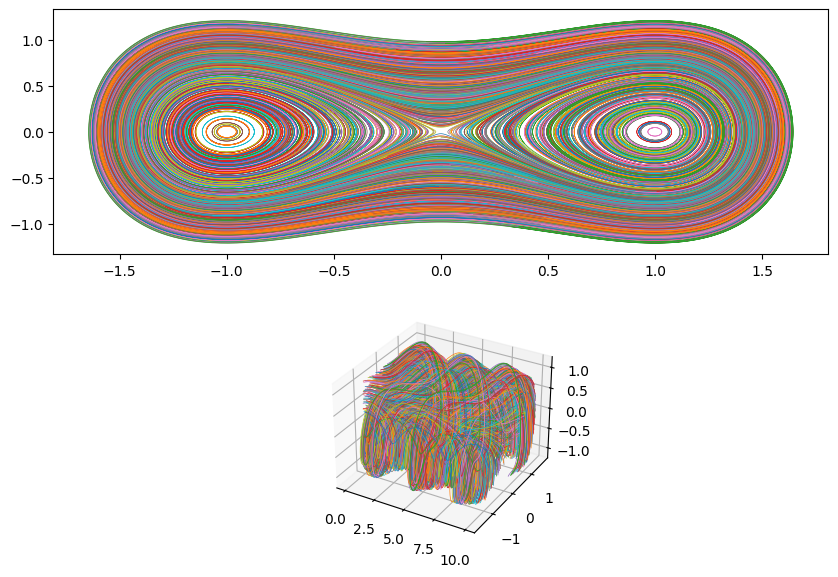

In [5]:
sys_params = {'gamma': 0., 'alpha':-1., 'beta':1., 'delta': 0.0, 'omega': 0.}
# Time points
# dt = 1/2**18
dt = 0.001
t = np.arange(0, 10, dt)
print('Number of points: ', len(t))

# Initial condition
z0s = np.random.rand(1024, 2) * 2 - 1
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(211)
# Create a 3D plot
ax_3d = fig.add_subplot(212, projection='3d')


for z0 in z0s:
    # Simulate the Duffing dynamics
    z, _, _ = simulate_duffing(z0, t, **sys_params)

    # Extract the trajectory (x and y components)
    x = z[:, 0]
    y = z[:, 1]

    # Plot the trajectory
    ax.plot(x, y, lw=0.5)
    # plt.axis('off')  # Remove axes for a presentational plot
    ax_3d.plot(t, x, y, lw=0.5)
# print number of points
plt.show()

## Train SINDy to identify the system (no dimensional expansion)

In [26]:
import pysindy as ps

In [27]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {  }
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

In [28]:
dt = 0.001
z0 = z0s[0]
z, _, _ = simulate_duffing(z0, t, **sys_params)

# Library
feature_library = ps.PolynomialLibrary(degree=3)
differentiation_method = ps.FiniteDifference(order=2)
optimizer = ps.STLSQ(threshold=0.01)

# Instantiate and fit the SINDy model
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)

model.fit(z, t=dt)
model.print()


(x)' = 1.000 y
(y)' = 1.000 x + -1.000 x^3


In [13]:
def display_duffing_coefficients(sys_params):
    """
    Display the coefficients of the Duffing equation in a state space representation of two states.

    Arguments:
        sys_params - Dictionary containing the Duffing equation parameters.
    """
    gamma = sys_params.get('gamma', 0.0)
    alpha = sys_params.get('alpha', 1.0)
    beta = sys_params.get('beta', 1.0)
    delta = sys_params.get('delta', 0.0)
    omega = sys_params.get('omega', 1.0)

    # Collect terms
    terms = []
    if delta != 0:
        terms.append(f"-{delta:.3f} y")
    if alpha != 0:
        terms.append(f"- {alpha:.3f} x")
    if beta != 0:
        terms.append(f"- {beta:.3f} x^3")
    if gamma != 0:
        terms.append(f"+ {gamma:.3f} cos({omega:.3f} t)")

    # Join terms to form the equation
    equation = " ".join(terms)
    if not equation:  # if equation is empty, assign zero
        equation = "0"

    # Display the state space representation
    print("(x)' = y")
    print(f"(y)' = {equation}")

# Example usage
display_duffing_coefficients(sys_params)

(x)' = y
(y)' = - -1.000 x - 1.000 x^3


## Train Autoencoder on expanded dimension

In [14]:
import example_duffing
%load_ext autoreload
%autoreload 2
import importlib
importlib.reload(example_duffing)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'example_duffing' from '/Users/saschimi/Documents/github/SindyAutoencoders/examples/duffing/example_duffing.py'>

In [15]:
# generate training, validation, testing data
noise_strength = 1e-12
training_data = example_duffing.get_duffing_data(256, noise_strength=noise_strength, sys_params=sys_params)
validation_data = example_duffing.get_duffing_data(20, noise_strength=noise_strength, sys_params=sys_params)


input_dim:  8
points in high-dimensional dataset:  8
input_dim:  8
points in high-dimensional dataset:  8


In [16]:
print(training_data['x'].shape)

(256000, 8)


# Set up model and training parameters

In [37]:
params = {}

params['input_dim'] = training_data['x'].shape[1]
params['latent_dim'] = 2
params['model_order'] = 2
params['poly_order'] = 3
params['include_sine'] = False
params['library_dim'] = library_size(params['model_order']*params['latent_dim'], params['poly_order'], params['include_sine'], True)

# sequential thresholding parameters
params['sequential_thresholding'] = True
params['coefficient_threshold'] = 0.001
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'normal'

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_z'] = 0.0
params['loss_weight_sindy_x'] = 1e-4
params['loss_weight_sindy_regularization'] = 1e-5

params['activation'] = 'sigmoid'
params['widths'] = [64,32]

# training parameters
params['epoch_size'] = training_data['x'].shape[0]
params['batch_size'] = 1024
params['learning_rate'] = 1e-3

params['data_path'] = os.getcwd() + '/'
params['print_progress'] = True
params['print_frequency'] = 100

# training time cutoffs
params['max_epochs'] = 1001
params['refinement_epochs'] = 1001

# Run training experiments

In [39]:
num_experiments = 1
df = pd.DataFrame()
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)

    params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))

    params['save_name'] = 'duffing_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")

    tf.compat.v1.reset_default_graph()

    results_dict = train_network(training_data, validation_data, params)
    df = pd.concat([df, pd.DataFrame([{**results_dict, **params}])], ignore_index=True)

df.to_pickle('experiment_results_' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.pkl')

EXPERIMENT 0
